In [10]:
import xarray as xr
from GadiClient import GadiClient
import matplotlib.pyplot as plt
import numpy as np

In [20]:
s06 = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ACCESS1-0_r1i1p1_historical_s06_qm_lsm_1979_2005.nc",chunks={"time":100}).s06
qmean01 = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ACCESS1-0_r1i1p1_historical_qmean01_qm_lsm_1979_2005.nc",chunks={"time":100}).qmean01
lr13 = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ACCESS1-0_r1i1p1_historical_lr13_qm_lsm_1979_2005.nc",chunks={"time":100}).lr13
Umean06 = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ACCESS1-0_r1i1p1_historical_Umean06_qm_lsm_1979_2005.nc",chunks={"time":100}).Umean06
bdsd = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ACCESS1-0_r1i1p1_logit_aws_historical_1979_2005.nc",chunks={"time":100}).logit_aws


#For testing...
s06 = s06.sel({"time":s06.time.dt.year==2005})
qmean01 = qmean01.sel({"time":qmean01.time.dt.year==2005})
lr13 = lr13.sel({"time":lr13.time.dt.year==2005})
Umean06 = Umean06.sel({"time":Umean06.time.dt.year==2005})
bdsd = bdsd.sel({"time":bdsd.time.dt.year==2005})


In [13]:
GadiClient()

Client Scheduler: tcp://127.0.0.1:46659 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 1 Memory: 68.72 GB


In [14]:
dim = ("time","lat","lon")

f = xr.Dataset({
    "s06":(dim, s06), "qmean01":(dim, qmean01), "lr13":(dim, lr13), "Umean06":(dim, Umean06), "bdsd":(dim, bdsd)},
    coords={"time":s06.time, "lat":s06.lat, "lon":s06.lon}).chunk({"time":100})

In [15]:
from era5_spatial_cluster import era5_clustering, transform_era5, load_cluster
cluster_mod, cluster_input = load_cluster()

In [16]:
s06_transform, qmean01_transform, lr13_transform, Umean06_transform = transform_era5(f, cluster_mod, cluster_input)

In [17]:
access_cluster = era5_clustering(s06_transform.fillna(0), 
                                 qmean01_transform.fillna(0), 
                                 lr13_transform.fillna(0), 
                                 Umean06_transform.fillna(0), 
                                 f, cluster_mod)

nulls = (s06_transform.isnull() | qmean01_transform.isnull() | lr13_transform.isnull() | Umean06_transform.isnull())
access_cluster = xr.where(nulls, np.nan, access_cluster)

In [18]:
era5_cluster = access_cluster

dim=("time","lat","lon")

out_ds = xr.Dataset({"cluster1":(dim, (era5_cluster.cluster==0).resample({"time":"1M"}).mean("time")),
          "cluster2":(dim, (era5_cluster.cluster==1).resample({"time":"1M"}).mean("time")),
          "cluster3":(dim, (era5_cluster.cluster==2).resample({"time":"1M"}).mean("time")),
          "cluster1_bdsd":(dim, ((era5_cluster.cluster==0) & (era5_cluster.bdsd>0.83)).resample({"time":"1M"}).mean("time")),
          "cluster2_bdsd":(dim, ((era5_cluster.cluster==1) & (era5_cluster.bdsd>0.83)).resample({"time":"1M"}).mean("time")),
          "cluster3_bdsd":(dim, ((era5_cluster.cluster==2) & (era5_cluster.bdsd>0.83)).resample({"time":"1M"}).mean("time"))
          },
          coords={"lat":(("lat"), era5_cluster.lat.values), "lon":(("lon"), era5_cluster.lon.values)})

out_ds = xr.where(access_cluster.isel({"time":0}).cluster.isnull().drop("time"), np.nan, out_ds)


Text(0.5, 1.0, 'Fraction of times that belong to cluster 3\n and have BDSD > 0.83')

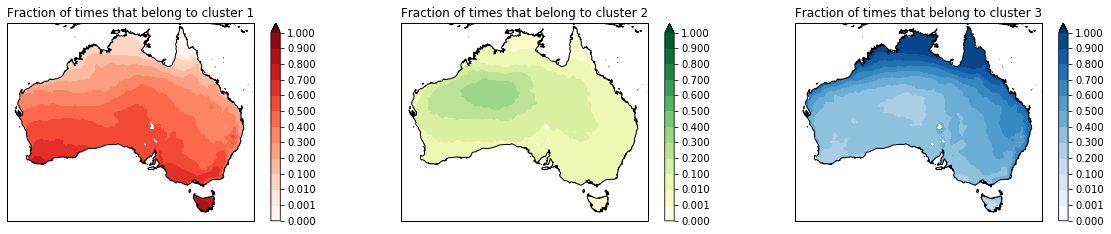

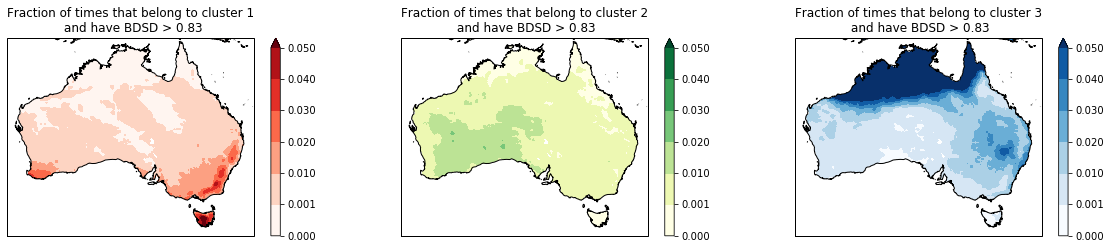

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

f = out_ds

levs=[0,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.figure(figsize=[20,8])
ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster1.mean("time"), cmap=plt.get_cmap("Reds"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 1")

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster2.mean("time"), cmap=plt.get_cmap("YlGn"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 2")

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster3.mean("time"), cmap=plt.get_cmap("Blues"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 3")




levs=[0,0.001,0.01,0.02,0.03,0.04,0.05]

plt.figure(figsize=[20,8])
ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster1_bdsd.mean("time"), cmap=plt.get_cmap("Reds"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 1\n and have BDSD > 0.83")

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster2_bdsd.mean("time"), cmap=plt.get_cmap("YlGn"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 2\n and have BDSD > 0.83")

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster3_bdsd.mean("time"), cmap=plt.get_cmap("Blues"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 3\n and have BDSD > 0.83")